In [1]:
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform
import pathlib
import random
from tensorflow import keras
import math
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Windows-10-10.0.22621-SP0
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
Pandas 1.5.1
Scikit-Learn 1.1.3
SciPy 1.9.3
GPU is available


In [2]:
# Variables and params
BATCH_SIZE = 350
NUM_EPOCH = 200
BUFFER_SIZE = math.ceil( (8*1024*1024*1024*5)/(256*256*3*8) )#how many images in 5GB of VRAM

train_root = pathlib.Path('../FruitScale/dataextended/Training')
train_root = train_root.resolve()

test_root = pathlib.Path('../FruitScale/dataextended/Test')
test_root = test_root.resolve()

random.seed(42)

In [3]:
# Useful functions
def create_image_tensor(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    grayscale = tf.image.rgb_to_grayscale(image)
    hsv = tf.image.rgb_to_hsv(image)
    res = tf.concat([hsv, grayscale], 2)
    #res = image
    return res

def augment(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.random_hue(image, 0.02)
    image = tf.image.random_hue(image, 0.02)
    image = tf.image.random_saturation(image, 0.9, 1.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return create_image_tensor(image)

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rgb_to_hsv(image)
    #image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.resize(image, [256, 256])
    return image
    #return augment(image)

In [4]:
# Setting labels and image paths
all_image_paths = list(train_root.glob('*/*'))
all_image_paths_test = list(test_root.glob('*/*'))
random.shuffle(all_image_paths)
random.shuffle(all_image_paths_test)
#print(all_image_paths[10])

total_image_count = len(all_image_paths)
total_image_count_test = len(all_image_paths_test)

validation_count = math.ceil(total_image_count * 0.20)
training_count = total_image_count - validation_count

# Training images
train_labels = [str(path.parent.name) for path in all_image_paths[0: training_count]]
train_image_path = [str(path) for path in all_image_paths[0: training_count]]
train_labels = list(dict.fromkeys(train_labels))
print("Number of train labels: " + str(len(train_labels)))
print("total training count: " + str(len(train_image_path)))
print(train_labels)

# Validation images
validation_labels = [str(path.parent.name) for path in all_image_paths[training_count:]]
validation_image_path = [str(path) for path in all_image_paths[training_count:]]
validation_labels = list(dict.fromkeys(validation_labels))
print("Number of validation labels: " + str(len(validation_labels)))
print("total validation count: " + str(len(validation_image_path)))

# Test images
test_labels = [str(path.parent.name) for path in all_image_paths_test]
test_image_path = [str(path) for path in all_image_paths_test]
test_labels = list(dict.fromkeys(test_labels))
print("Number of test labels: " + str(len(test_labels)))
print("total test count: " + str(len(test_image_path)))

#Generating index
label_to_index = dict((name, index) for index, name in enumerate(train_labels))
#print(label_to_index)

train_labels = [label_to_index[pathlib.Path(path).parent.name]
                for path in train_image_path]

validation_labels = [label_to_index[pathlib.Path(path).parent.name]
                     for path in validation_image_path]

test_labels = [label_to_index[pathlib.Path(path).parent.name]
               for path in test_image_path]

#print(len(train_labels))

Number of train labels: 131
total training count: 354080
['Pomelo Sweetie', 'Cherry Wax Red', 'Tamarillo', 'Beetroot', 'Mandarine', 'Grape Blue', 'Apple Golden 1', 'Grape White 4', 'Kiwi', 'Mangostan', 'Rambutan', 'Corn Husk', 'Lemon Meyer', 'Pear Williams', 'Blueberry', 'Cherry Rainier', 'Tomato 4', 'Pear Kaiser', 'Cactus fruit', 'Pepper Orange', 'Guava', 'Kaki', 'Potato White', 'Apple Red Yellow 2', 'Physalis with Husk', 'Watermelon', 'Walnut', 'Salak', 'Tomato 1', 'Plum 2', 'Hazelnut', 'Pepino', 'Apple Red 1', 'Grapefruit Pink', 'Peach', 'Apple Pink Lady', 'Apple Red 3', 'Pineapple', 'Peach 2', 'Pear', 'Pepper Yellow', 'Onion White', 'Pear Red', 'Corn', 'Pear Abate', 'Strawberry Wedge', 'Banana', 'Cherry Wax Yellow', 'Apple Golden 3', 'Tomato Heart', 'Strawberry', 'Apple Red Yellow 1', 'Apple Red Delicious', 'Granadilla', 'Cocos', 'Avocado', 'Tomato not Ripened', 'Pear Monster', 'Peach Flat', 'Physalis', 'Banana Lady Finger', 'Mango Red', 'Limes', 'Dates', 'Potato Sweet', 'Tangelo',

In [5]:
# Generating the training data set
train_path_ds = tf.data.Dataset.from_tensor_slices(train_image_path)
train_image_ds = train_path_ds.map(load_image, tf.data.AUTOTUNE)
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.uint8))

train_data = tf.data.Dataset.zip((train_image_ds, train_label_ds))

#ds = data.apply(tf.data.Dataset.shuffle(buffer_size=100000))

train_ds = train_data.shuffle(buffer_size=math.ceil(BUFFER_SIZE))
train_ds = train_ds.batch(BATCH_SIZE)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
# Generating the validation dataset
validation_path_ds = tf.data.Dataset.from_tensor_slices(validation_image_path)
validation_image_ds = validation_path_ds.map(load_image, tf.data.AUTOTUNE)
validation_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(validation_labels, tf.uint8))

validation_data = tf.data.Dataset.zip((validation_image_ds, validation_label_ds))

#ds = data.apply(tf.data.Dataset.shuffle(buffer_size=100000))

validation_ds = validation_data.shuffle(buffer_size=math.ceil(BUFFER_SIZE))
validation_ds = validation_ds.batch(BATCH_SIZE)

validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
# Generating the test dataset
test_path_ds = tf.data.Dataset.from_tensor_slices(test_image_path)
test_image_ds = test_path_ds.map(load_image, tf.data.AUTOTUNE)
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.uint8))

print(len(test_image_ds))
print(len(test_label_ds))

test_data = tf.data.Dataset.zip((test_image_ds, test_label_ds))

#ds = data.apply(tf.data.Dataset.shuffle(buffer_size=100000))

test_ds = test_data.shuffle(buffer_size=math.ceil(total_image_count_test))
test_ds = test_ds.batch(BATCH_SIZE)

test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

22688
22688


In [8]:
base_model=tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(256,256,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [9]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout = tf.keras.layers.Dropout(0.5)
prediction_layer = tf.keras.layers.Dense(131, activation='softmax')
#model.layers.Add(keras.layers.GlobalAveragePooling2D())
#model.layers.Add(keras.layers.Dense(131,activation='softmax'))
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    #dropout,
    prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 131)               167811    
                                                                 
Total params: 2,425,795
Trainable params: 167,811
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True,)

In [11]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=NUM_EPOCH,
    validation_data=validation_ds,
    verbose=1,
    callbacks=[early_stop],
)

Epoch 1/200
1012/1012 [==============================] - 438s 411ms/step - loss: 0.6996 - accuracy: 0.8520 - val_loss: 0.2974 - val_accuracy: 0.9287
Epoch 2/200
1012/1012 [==============================] - 619s 591ms/step - loss: 0.2305 - accuracy: 0.9439 - val_loss: 0.2020 - val_accuracy: 0.9479
Epoch 3/200
1012/1012 [==============================] - 745s 713ms/step - loss: 0.1635 - accuracy: 0.9589 - val_loss: 0.1669 - val_accuracy: 0.9543
Epoch 4/200
1012/1012 [==============================] - 871s 833ms/step - loss: 0.1299 - accuracy: 0.9666 - val_loss: 0.1409 - val_accuracy: 0.9604
Epoch 5/200
1012/1012 [==============================] - 1033s 989ms/step - loss: 0.1085 - accuracy: 0.9722 - val_loss: 0.1290 - val_accuracy: 0.9623
Epoch 6/200
1012/1012 [==============================] - 1129s 1s/step - loss: 0.0935 - accuracy: 0.9760 - val_loss: 0.1173 - val_accuracy: 0.9650
Epoch 7/200
1012/1012 [==============================] - 1249s 1s/step - loss: 0.0821 - accuracy: 0.9789 - 

KeyboardInterrupt: 

In [12]:
model.save("trained_mobilenet_HSV_with_dropout.h5")

In [13]:
loss, acc, *is_anything_else_being_returned = model.evaluate(test_ds)
print('Loss:', loss)
print('Accuracy:', acc)

65/65 [==============================] - 191s 359ms/step - loss: 0.1634 - accuracy: 0.9647
Loss: 0.16335166990756989
Accuracy: 0.9646509289741516


In [14]:

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

NameError: name 'history' is not defined

<Figure size 800x800 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [15]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

print(confusion_matrix(y_true=correct_labels, y_pred=predicted_labels))

9/9 [==============================] - 0s 31ms/step
[[153   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 166 ...   0   0   0]
 ...
 [  0   0   0 ... 162   0   0]
 [  0   0   0 ...   0 160   0]
 [  0   0   0 ...   0   0 144]]


In [16]:
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       164
           2       0.99      1.00      1.00       166
           3       0.94      0.99      0.96       150
           4       1.00      0.98      0.99       166
           5       1.00      1.00      1.00       328
           6       0.98      0.97      0.97       160
           7       0.99      1.00      0.99       158
           8       0.97      1.00      0.99       156
           9       0.98      0.98      0.98       102
          10       0.99      1.00      0.99       164
          11       1.00      0.68      0.81       154
          12       1.00      1.00      1.00       166
          13       0.90      0.97      0.93       166
          14       1.00      1.00      1.00       154
          15       0.96      1.00      0.98       246
          16       0.98      0.99      0.99       160
          17       1.00    

<AxesSubplot: >

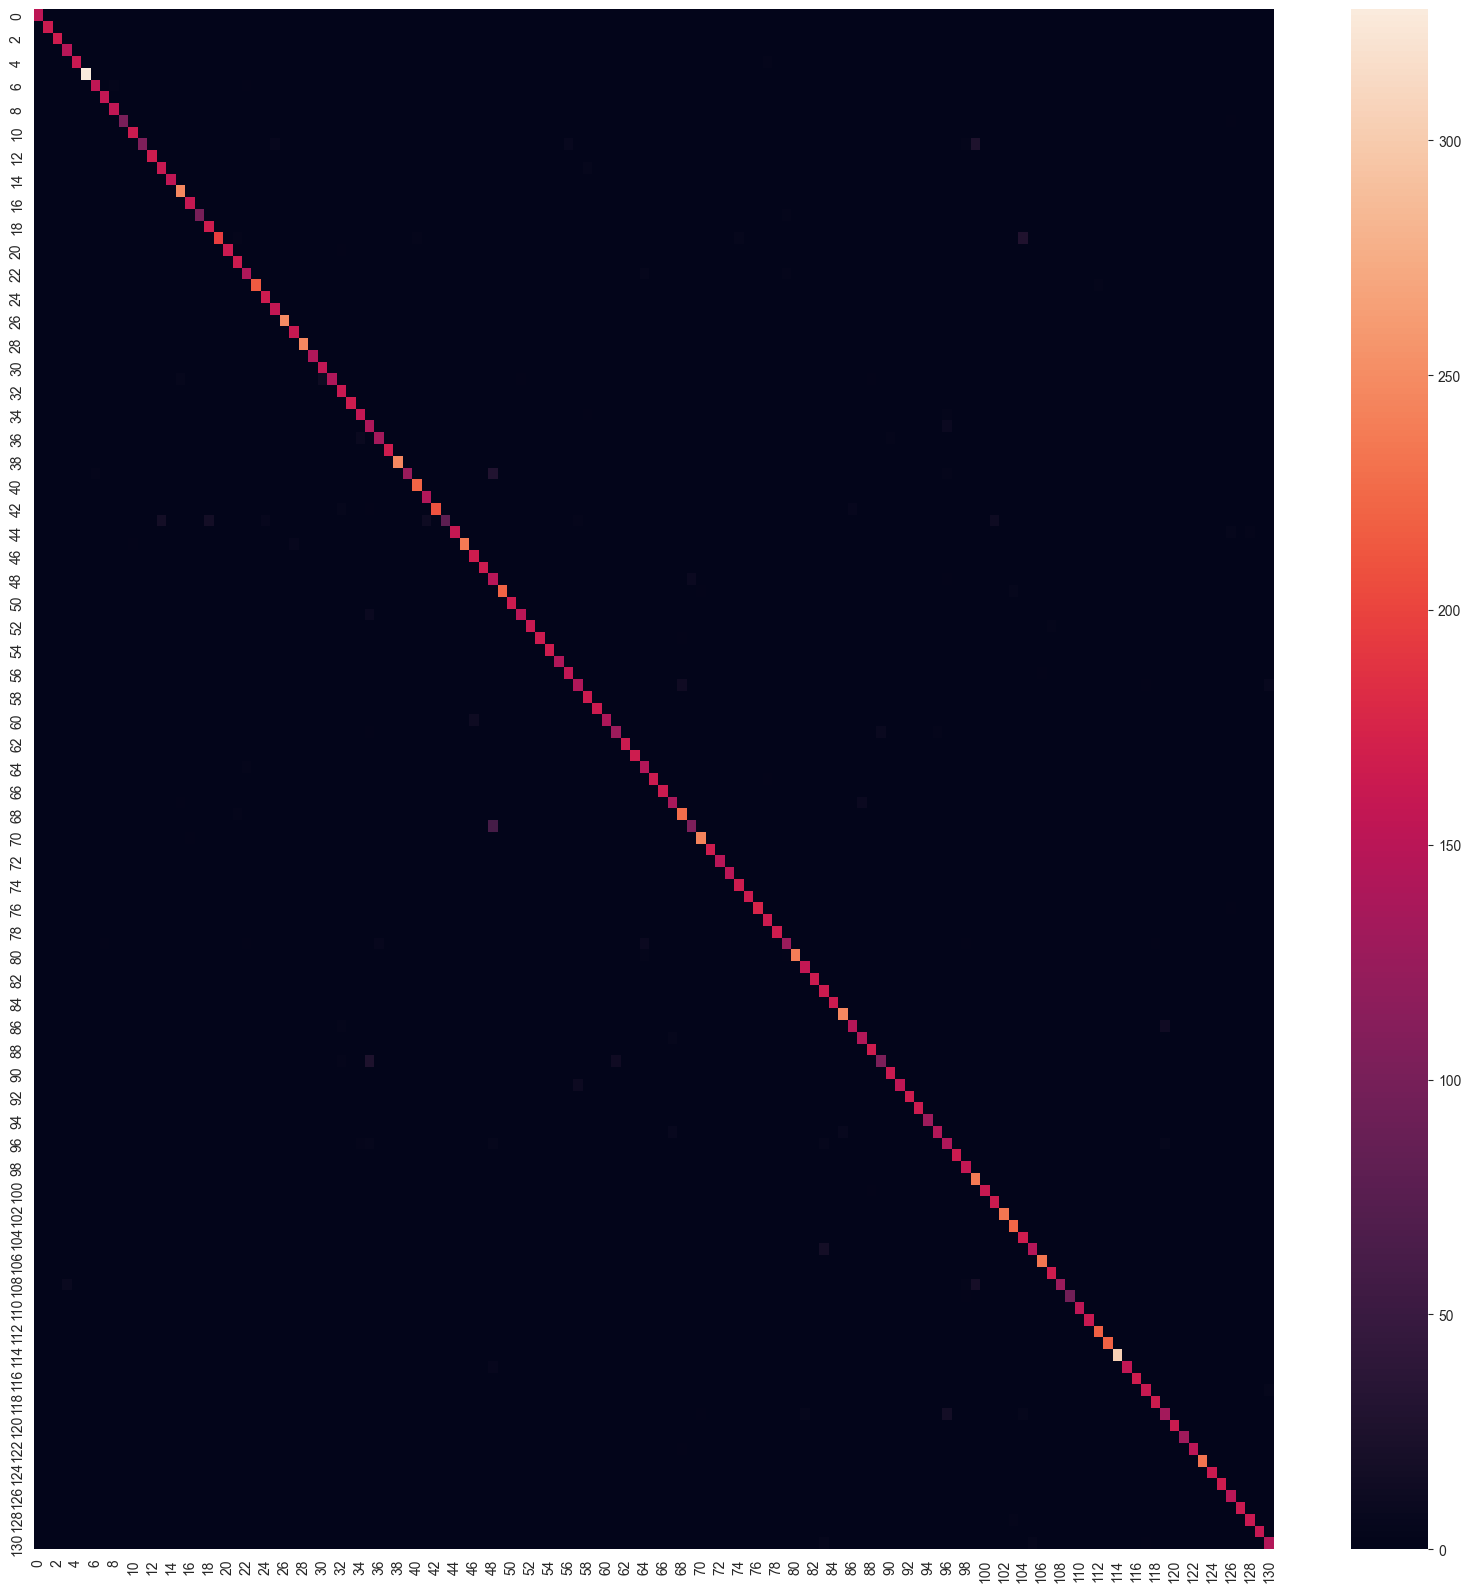

In [17]:
cf_matrix = confusion_matrix(y_true=correct_labels, y_pred=predicted_labels)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cf_matrix, ax=ax,)

In [18]:
index = label_to_index#list(label_to_index.keys())
def getPredictionClass(predictions):
    i=0
    for prediction in predictions:
        if prediction > 0.0:
            k = 0
            for a,b in index.items():
                if k == i:
                    print(a + ": " + str(prediction))
                k = k + 1
        i = i+1

76.jpg
1/1 [==============================] - 0s 24ms/step
Apple Red 3: 1.0


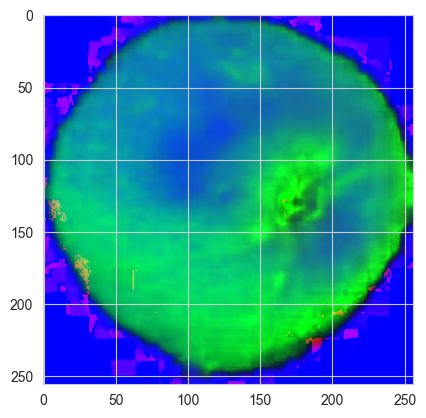

In [54]:
import cv2

x = random.choice(os.listdir(str(test_root) + '/Apple Red 3'))
print(x)
img = plt.imread(os.path.join(str(test_root) + '/Apple Red 3', x))
img = cv2.resize(img, dsize=(256, 256))
img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#img_new = keras.applications.mobilenet.preprocess_input(img)
plt.imshow(img)
img = img/256
#print(img.shape)
#print((np.expand_dims(img,0).shape))

predictions = model.predict(np.expand_dims(img,0)).round(2)[0]
#print(predictions)
getPredictionClass(predictions)